# INIT

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerias

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

## Importacion datos

In [5]:
from modules.get_data import get_data

In [6]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_ws = get_data('exp_weekly_sales.csv')

# Añadir año y semana a calendar para poder añadir eventos a weekly sales
df_cal['fecha'] = pd.to_datetime(df_cal['fecha'])

df_cal['year'] = df_cal['fecha'].dt.year
df_cal['week'] = df_cal['fecha'].dt.isocalendar().week

# Renombrar columnas específicas
df_ws = df_ws.rename(columns={ #ejercicio, semana, unidades, cifra
    'ejercicio': 'year',
    'semana': 'week',
    'unidades': 'units',
    'cifra': 'raw_earn',
    })

# Añadir la columna 'event' a df_ws usando el método 'map'
# Crear un diccionario desde df_cal
event_dict = df_cal.set_index('week')['event'].to_dict()
df_ws['event'] = df_ws['week'].map(event_dict)

# Rellenar NaN columna event de df_ws con 'None' (str)
df_ws['event'] = df_ws['event'].fillna('None')

display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,fecha,event,year,week
0,2011-02-06,SuperBowl,2011,5
1,2011-08-01,Ramadan starts,2011,31
2,2011-11-24,Thanksgiving,2011,47
3,2012-01-01,NewYear,2012,52
4,2012-02-05,SuperBowl,2012,5


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,year,week,units,sell_price,raw_earn,event
0,ACCESORIES_1_004,BOS_1,2011,4,3.0,5.77,17.32,None
1,ACCESORIES_1_004,BOS_2,2011,4,8.0,5.77,46.18,None
2,ACCESORIES_1_004,NYC_2,2011,4,9.0,5.77,51.95,None
3,ACCESORIES_1_004,NYC_4,2011,4,2.0,5.77,11.54,None
4,ACCESORIES_1_004,PHI_1,2011,4,3.0,5.77,17.32,None


___
___

# CREACION FEATS. GENERALES

In [7]:
!pip install featuretools # install the missing module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 14.8 MB/s eta 0:00:00


In [8]:
from modules import feature_creation_module as fcm

In [15]:
df_ws = df_ws.drop(columns=['event']) # no nos sirve ahora

In [16]:
# Creacion caracteristicas globales para tiendas (luego iremos filtrando)
fc_config = {
    'target_df': 'shops',  # El DataFrame que contiene información sobre las tiendas
    'agg_primitives': [
        'min',               # Mínimo
        'max',               # Máximo
        'mean',              # Promedio
        'std',               # Desviación estándar
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        'month',  # Extrae el mes para observar patrones estacionales a nivel semanal
        'is_weekend'  # Indica si la semana incluye fines de semana
    ],
    'max_depth': 2  # Profundidad máxima de las características generadas
}

feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a f

In [17]:
feature_matrix.head()

,COUNT(sales),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MAX(sales.week),MAX(sales.year),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.units),MEAN(sales.week),...,STD(sales.raw_earn),STD(sales.sell_price),STD(sales.units),STD(sales.week),STD(sales.year),SUM(sales.raw_earn),SUM(sales.sell_price),SUM(sales.units),SUM(sales.week),SUM(sales.year)
store_code,,,,,,,,,,,,,,,,,,,,,
NYC_1,534101,4153.32,41.20,1697.0,53.0,2016.0,51.929222,5.392711,14.413409,25.952865,...,89.614280,4.335884,29.263064,15.217839,1.494006,27735449.19,2880252.29,7698216.0,13861451.0,1.075428e+09
NYC_2,474612,1613.52,41.20,638.0,53.0,2016.0,45.315173,5.466066,11.979206,26.073260,...,58.430267,4.404013,19.189855,15.327575,1.512879,21507125.12,2594260.38,5685475.0,12374682.0,9.556815e+08
NYC_3,552278,8623.37,41.20,3976.0,53.0,2016.0,71.507726,5.353441,20.258240,26.025523,...,130.058981,4.309431,46.523097,15.285107,1.492768,39492143.82,2956587.60,11188180.0,14373324.0,1.112039e+09
NYC_4,482465,1744.99,41.20,567.0,53.0,2016.0,31.187712,5.299665,8.505645,25.996731,...,42.174182,4.288933,13.680758,15.247461,1.499930,15046979.58,2556902.75,4103676.0,12542513.0,9.714673e+08
BOS_1,495985,2219.70,65.77,1676.0,53.0,2016.0,38.995716,5.212343,11.281172,25.951962,...,66.422400,4.178037,25.052432,15.243287,1.507499,19341290.34,2585243.70,5595292.0,12871784.0,9.986713e+08


## Descripciones

In [18]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: COUNT(sales)>: The number of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.raw_earn)>: The maximum of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.sell_price)>: The maximum of the "sell_price" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.units)>: The maximum of the "units" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.week)>: The maximum of the "week" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.year)>: The maximum of the "year" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: ME

# **TIENDAS: PERFORMANCE VENTAS GENERAL**  
  
Esta configuración se centra en la evaluación general del rendimiento de ventas en cada tienda.


___
___

## Selección caracteristicas

In [19]:
# V3
substrings = ['(sales)', '(sales.'] # Nos quedamos solo con las que afectan al precio de venta

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 26
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 26
Shape after filtering: 14
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,COUNT(sales),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.week),MEAN(sales.year),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.sell_price),STD(sales.units),STD(sales.week),STD(sales.year)
store_code,,,,,,,,,,,,,,
NYC_1,534101,4153.32,41.20,1697.0,51.929222,5.392711,25.952865,2013.528791,0.07,89.614280,4.335884,29.263064,15.217839,1.494006
NYC_2,474612,1613.52,41.20,638.0,45.315173,5.466066,26.073260,2013.605870,0.24,58.430267,4.404013,19.189855,15.327575,1.512879
NYC_3,552278,8623.37,41.20,3976.0,71.507726,5.353441,26.025523,2013.549663,0.01,130.058981,4.309431,46.523097,15.285107,1.492768
NYC_4,482465,1744.99,41.20,567.0,31.187712,5.299665,25.996731,2013.549835,0.04,42.174182,4.288933,13.680758,15.247461,1.499930
BOS_1,495985,2219.70,65.77,1676.0,38.995716,5.212343,25.951962,2013.511169,0.12,66.422400,4.178037,25.052432,15.243287,1.507499


## Preprocesamiento datos

In [20]:
from modules import preprocessing_module as pm

scaled_df = pm.preprocess_features(feature_matrix_renamed)

scaled_df.head()

Cat cols: 0
Num cols: 14


,COUNT(sales),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.week),MEAN(sales.year),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.sell_price),STD(sales.units),STD(sales.week),STD(sales.year)
0,1.154883,0.596752,0.000000,0.282982,0.908654,0.883771,-0.253913,-0.248072,0.000000,0.265447,0.572092,0.013180,-1.288504,-0.376274
1,-0.553123,-0.554384,0.000000,-0.908579,0.044804,1.525698,1.198394,0.762306,3.090909,-0.784661,1.267783,-0.939507,1.195378,0.949179
2,1.676768,2.622752,0.000000,2.847257,3.465769,0.540119,0.622557,0.025528,-1.090909,1.627404,0.301967,1.645569,0.234109,-0.463267
3,-0.327653,-0.494796,0.000000,-0.988467,-1.800360,0.069526,0.275243,0.027774,-0.545455,-1.332077,0.092652,-1.460536,-0.618009,0.039718
4,0.060523,-0.279639,1.270424,0.259353,-0.780570,-0.694630,-0.264799,-0.479078,0.909091,-0.515529,-1.039763,-0.385046,-0.712472,0.571338


## Kmeans

### Elbow & Silhoutee

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

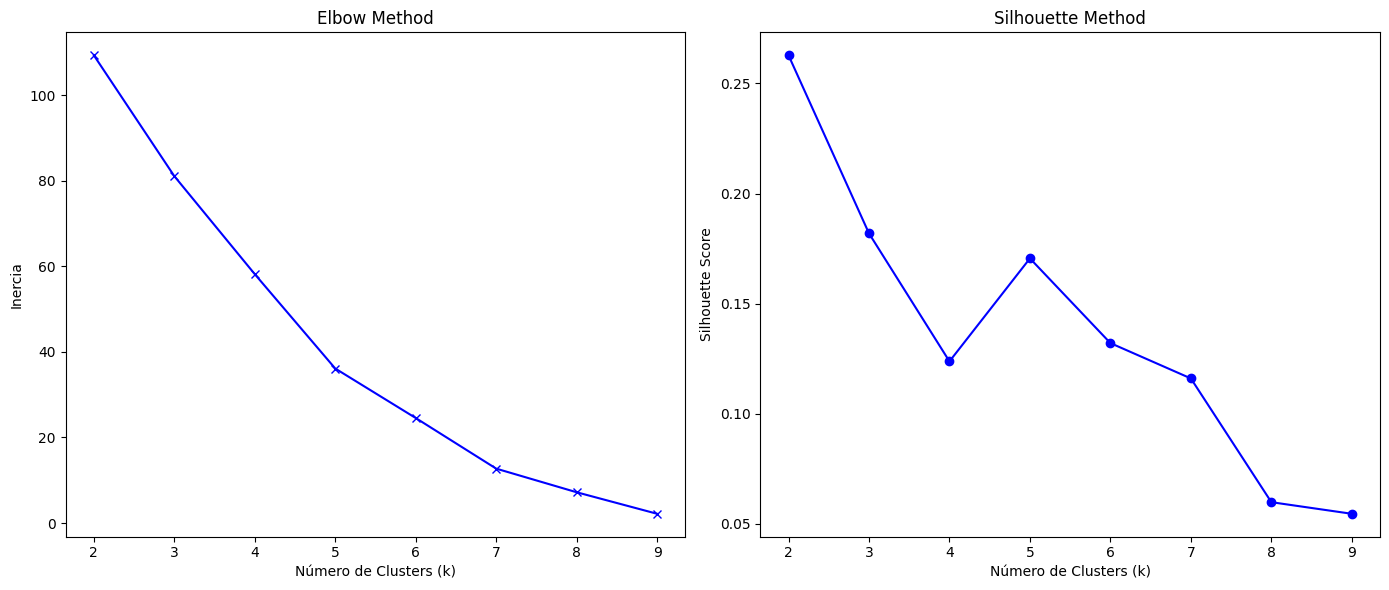

In [21]:
from modules import kmeans_module as km_m

km_m.plot_elbow_silhouette(scaled_df, 9)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


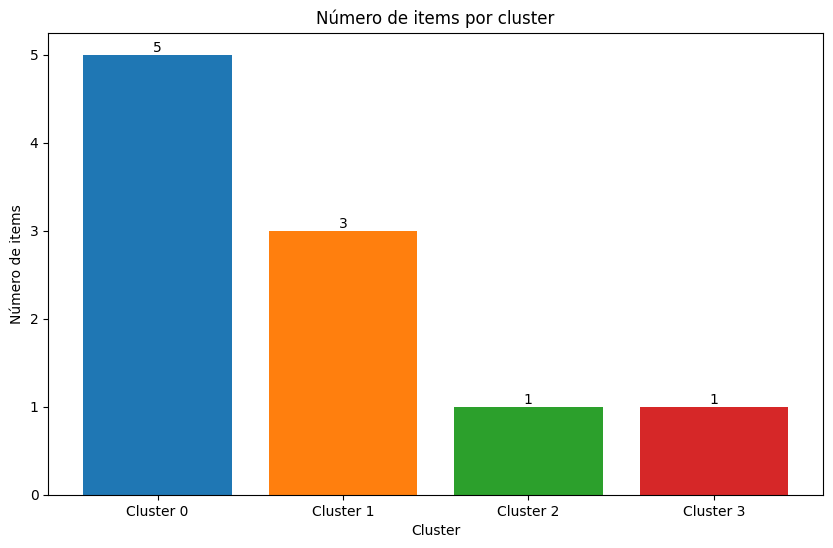

,COUNT(sales),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.week),MEAN(sales.year),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.sell_price),STD(sales.units),STD(sales.week),STD(sales.year),Cluster
store_code,,,,,,,,,,,,,,,
NYC_1,534101,4153.32,41.20,1697.0,51.929222,5.392711,25.952865,2013.528791,0.07,89.614280,4.335884,29.263064,15.217839,1.494006,0
NYC_2,474612,1613.52,41.20,638.0,45.315173,5.466066,26.073260,2013.605870,0.24,58.430267,4.404013,19.189855,15.327575,1.512879,1
NYC_3,552278,8623.37,41.20,3976.0,71.507726,5.353441,26.025523,2013.549663,0.01,130.058981,4.309431,46.523097,15.285107,1.492768,3
NYC_4,482465,1744.99,41.20,567.0,31.187712,5.299665,25.996731,2013.549835,0.04,42.174182,4.288933,13.680758,15.247461,1.499930,1
BOS_1,495985,2219.70,65.77,1676.0,38.995716,5.212343,25.951962,2013.511169,0.12,66.422400,4.178037,25.052432,15.243287,1.507499,0


In [22]:
# Apreciamos varias opciones 4
optimal_k = 4

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

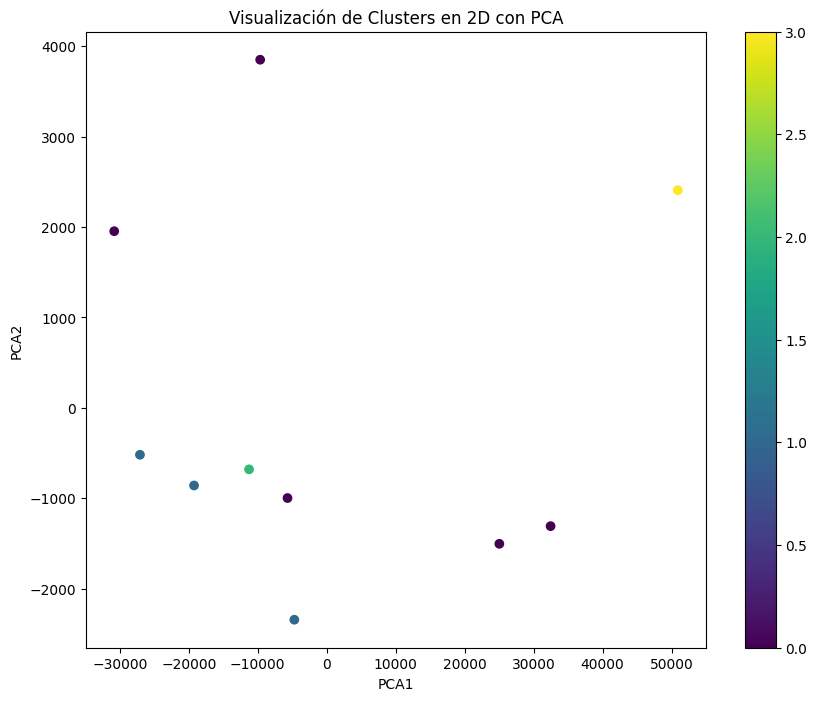

,PCA1,PCA2,Cluster
0,32464.726991,-1308.364494,0
1,-27079.178570,-519.225667,1
2,50917.598876,2407.203117,3
3,-19236.392246,-858.659379,1
4,-5682.863702,-997.552013,0


In [23]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 0.99


array([0.99422952])

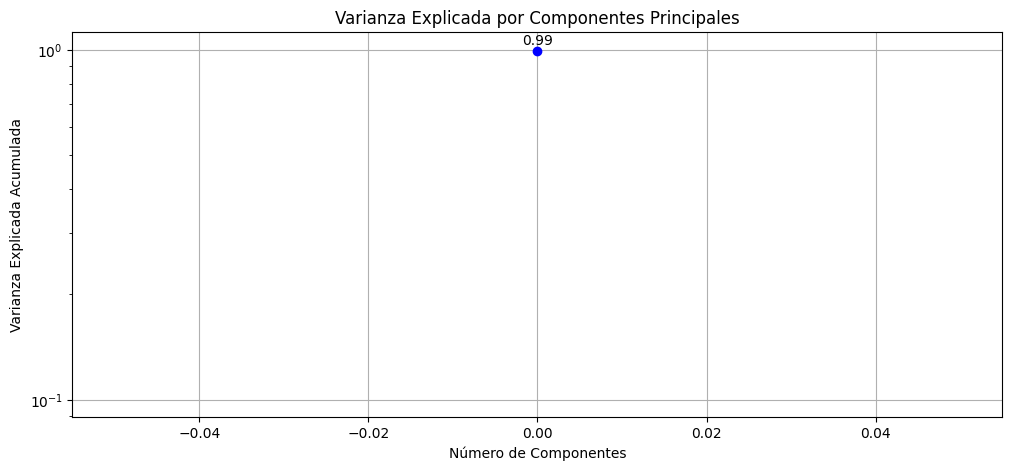

In [24]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

display(explained_variance)

### Importancia caracteristicas

Cat cols: 0
Num cols: 14


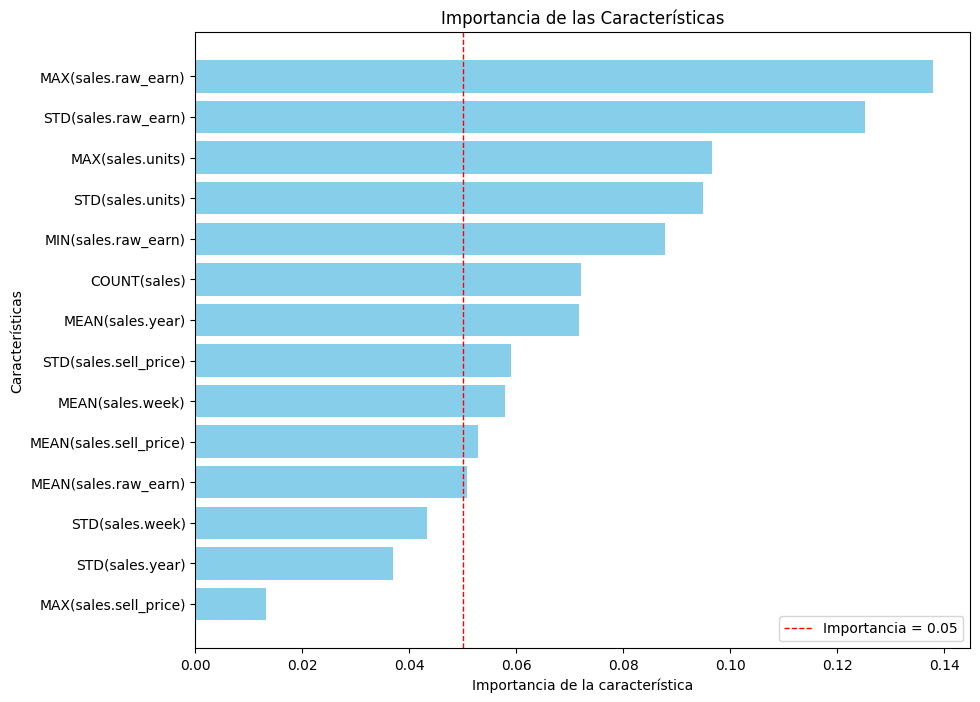

,Feature,Importance
0,MAX(sales.raw_earn),0.137958
1,STD(sales.raw_earn),0.125208
2,MAX(sales.units),0.096635
3,STD(sales.units),0.094935
4,MIN(sales.raw_earn),0.087795
5,COUNT(sales),0.072091
6,MEAN(sales.year),0.071627
7,STD(sales.sell_price),0.058904
8,MEAN(sales.week),0.057775
9,MEAN(sales.sell_price),0.052884


In [25]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

### Dim redux

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


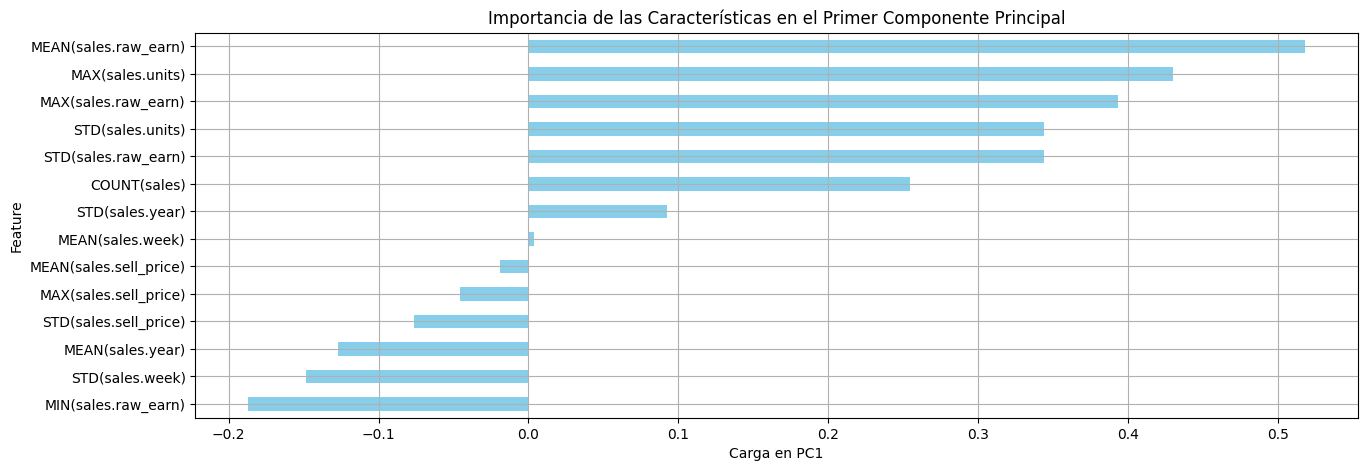

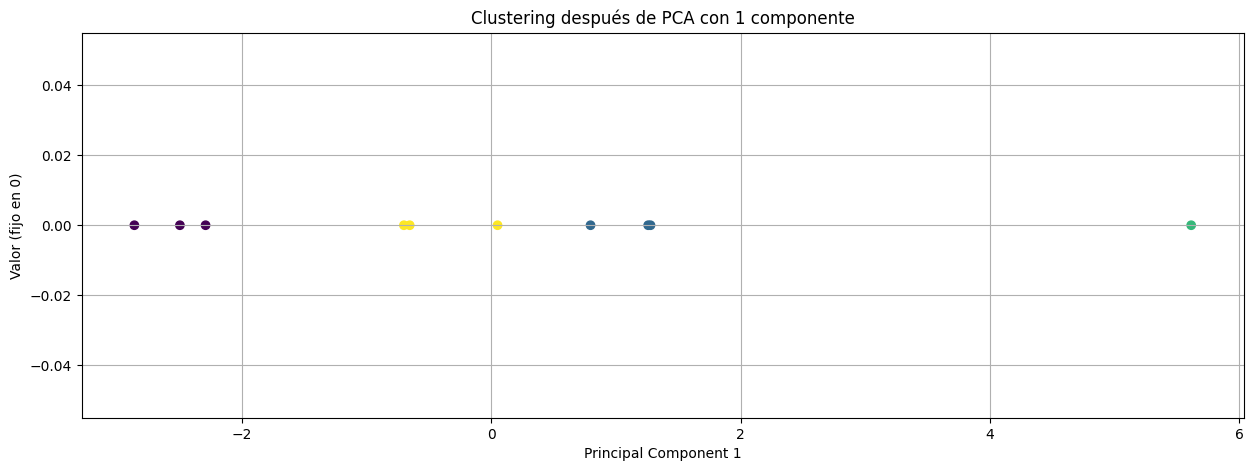

In [26]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

## Descripcion de clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,COUNT(sales),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.week),MEAN(sales.year),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.sell_price),STD(sales.units),STD(sales.week),STD(sales.year),PC1,Cluster
0,1.154883,0.596752,0.000000,0.282982,0.908654,0.883771,-0.253913,-0.248072,0.000000,0.265447,0.572092,0.013180,-1.288504,-0.376274,1.259132,1
1,-0.553123,-0.554384,0.000000,-0.908579,0.044804,1.525698,1.198394,0.762306,3.090909,-0.784661,1.267783,-0.939507,1.195378,0.949179,-2.289697,0
2,1.676768,2.622752,0.000000,2.847257,3.465769,0.540119,0.622557,0.025528,-1.090909,1.627404,0.301967,1.645569,0.234109,-0.463267,5.613150,2
3,-0.327653,-0.494796,0.000000,-0.988467,-1.800360,0.069526,0.275243,0.027774,-0.545455,-1.332077,0.092652,-1.460536,-0.618009,0.039718,-2.495529,0
4,0.060523,-0.279639,1.270424,0.259353,-0.780570,-0.694630,-0.264799,-0.479078,0.909091,-0.515529,-1.039763,-0.385046,-0.712472,0.571338,-0.699411,3


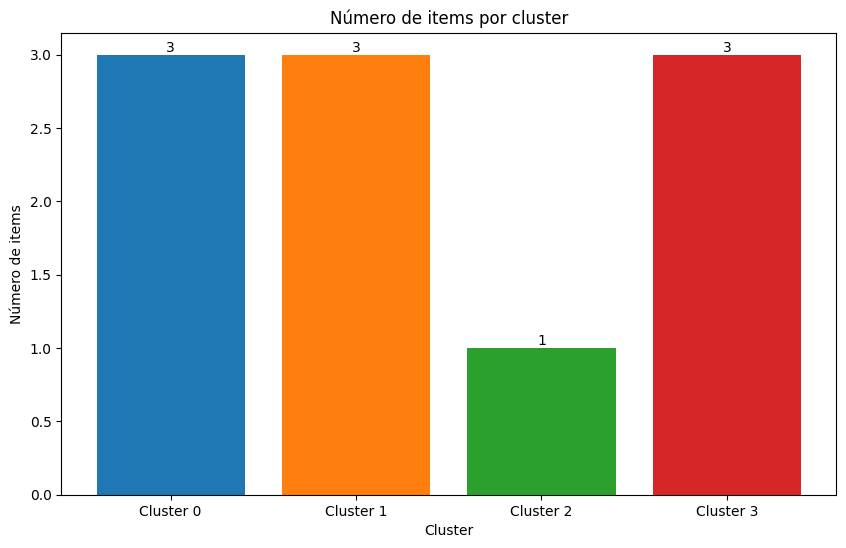

In [27]:
# Ejecutar PCA y clustering
optimal_k = 4
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

In [28]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,1,0,2,3
MEAN(sales.raw_earn),0.418622,-0.945924,3.465769,-0.330563
MAX(sales.units),0.244351,-0.915706,2.847257,0.073324
MAX(sales.raw_earn),0.916358,-0.615133,2.622752,-0.041275
STD(sales.units),0.166234,-1.188062,1.645569,-0.051637
STD(sales.raw_earn),0.479071,-1.092933,1.627404,-0.171843
COUNT(sales),0.678745,-0.263082,1.676768,-0.234590
STD(sales.year),0.034639,-0.632557,-0.463267,-0.391764


In [29]:
description_df[sorted(description_df.columns)]

,0,1,2,3
MEAN(sales.raw_earn),-0.945924,0.418622,3.465769,-0.330563
MAX(sales.units),-0.915706,0.244351,2.847257,0.073324
MAX(sales.raw_earn),-0.615133,0.916358,2.622752,-0.041275
STD(sales.units),-1.188062,0.166234,1.645569,-0.051637
STD(sales.raw_earn),-1.092933,0.479071,1.627404,-0.171843
COUNT(sales),-0.263082,0.678745,1.676768,-0.234590
STD(sales.year),-0.632557,0.034639,-0.463267,-0.391764


In [30]:
# Añadimos clusters a df_items
df_shops = df_shops.reset_index(drop=True) # Recuperamos indices originales

df_shops_with_clusters = df_shops.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_shops_with_clusters.head()

,store_code,region,store,Cluster
0,NYC_1,New York,Greenwich_Village,1
1,NYC_2,New York,Harlem,0
2,NYC_3,New York,Tribeca,2
3,NYC_4,New York,Brooklyn,0
4,BOS_1,Boston,South_End,3


In [31]:
# ordenar este df por cluster ascendente
df_shops_with_clusters = df_shops_with_clusters.sort_values(by='Cluster')
df_shops_with_clusters # ordenar por cluster


,store_code,region,store,Cluster
1,NYC_2,New York,Harlem,0
3,NYC_4,New York,Brooklyn,0
7,PHI_1,Philadelphia,Midtown_Village,0
0,NYC_1,New York,Greenwich_Village,1
5,BOS_2,Boston,Roxbury,1
6,BOS_3,Boston,Back_Bay,1
2,NYC_3,New York,Tribeca,2
4,BOS_1,Boston,South_End,3
8,PHI_2,Philadelphia,Yorktown,3
9,PHI_3,Philadelphia,Queen_Village,3


In [32]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Low Sales Performance',
        'description': 'Tiendas con bajo desempeño en ventas generales. Este grupo tiene ingresos promedio bajos, pocas ventas máximas y una baja variabilidad tanto en las unidades vendidas como en los ingresos. Son tiendas con ventas consistentes pero limitadas en volumen.'
    },
    1: {
        'cluster_name': 'Moderate Sales and Stable Performance',
        'description': 'Tiendas con un rendimiento de ventas moderado y relativamente estable. Tienen ingresos promedio ligeramente por encima de la media, con un desempeño aceptable en las ventas máximas, y muestran una variabilidad moderada en los ingresos y unidades vendidas.'
    },
    2: {
        'cluster_name': 'High Sales Performance',
        'description': 'Tiendas con un alto desempeño en ventas generales. Estas tiendas generan altos ingresos, tienen picos significativos de ventas y muestran una gran variabilidad en las ventas y los ingresos. Son tiendas dinámicas que experimentan volúmenes de ventas sustanciales y fluctuaciones significativas.'
    },
    3: {
        'cluster_name': 'Underperforming Stores',
        'description': 'Tiendas con un desempeño por debajo del promedio. Aunque estas tiendas tienen ventas más estables que las del cluster de bajo desempeño, aún presentan ingresos bajos y una variabilidad reducida en las ventas. No alcanzan picos de ventas importantes ni muestran fluctuaciones significativas.'
    }
}


cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
shops_with_cluster_info = df_shops_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `shops_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(shops_with_cluster_info.head())

,store_code,region,store,Cluster,cluster_name,description
1,NYC_2,New York,Harlem,0,Low Sales Performance,Tiendas con bajo desempeño en ventas generales...
3,NYC_4,New York,Brooklyn,0,Low Sales Performance,Tiendas con bajo desempeño en ventas generales...
7,PHI_1,Philadelphia,Midtown_Village,0,Low Sales Performance,Tiendas con bajo desempeño en ventas generales...
0,NYC_1,New York,Greenwich_Village,1,Moderate Sales and Stable Performance,Tiendas con un rendimiento de ventas moderado ...
5,BOS_2,Boston,Roxbury,1,Moderate Sales and Stable Performance,Tiendas con un rendimiento de ventas moderado ...


## Guardar CSV

In [33]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_global_sales_performance.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# shops_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

# **MIX DE PRODUCTOS: Segun cluster performance ventas global**  
  
Esta configuración se centra en entender la variedad y popularidad de los productos en diferentes tiendas.
___
___

## Importacion de datos

In [56]:
df_items_sp_clusters = get_data('items_clusters_sales_performance.csv')
df_shops = get_data('exp_shops.csv')
df_ws = get_data('exp_weekly_sales.csv')

# Añadir año y semana a calendar para poder añadir eventos a weekly sales
df_cal['fecha'] = pd.to_datetime(df_cal['fecha'])

df_cal['year'] = df_cal['fecha'].dt.year
df_cal['week'] = df_cal['fecha'].dt.isocalendar().week

# Renombrar columnas específicas
df_ws = df_ws.rename(columns={ #ejercicio, semana, unidades, cifra
    'ejercicio': 'year',
    'semana': 'week',
    'unidades': 'units',
    'cifra': 'raw_earn',
    })

# No vamos a usar eventos ahora
# # Añadir la columna 'event' a df_ws usando el método 'map'
# # Crear un diccionario desde df_cal
# event_dict = df_cal.set_index('week')['event'].to_dict()
# df_ws['event'] = df_ws['week'].map(event_dict)

# # Rellenar NaN columna event de df_ws con 'None' (str)
# df_ws['event'] = df_ws['event'].fillna('None')

In [57]:
display(df_items_sp_clusters.head())
display(df_shops.head())
display(df_ws.head())

,item,category,department,Cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,1,Moderate Performance,"Productos con rendimiento moderado, presentand..."
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,1,Moderate Performance,"Productos con rendimiento moderado, presentand..."
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,1,Moderate Performance,"Productos con rendimiento moderado, presentand..."
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,0,Low Performance,Productos con rendimiento muy bajo en todas la...
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,1,Moderate Performance,"Productos con rendimiento moderado, presentand..."


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,year,week,units,sell_price,raw_earn
0,ACCESORIES_1_004,BOS_1,2011,4,3.0,5.77,17.32
1,ACCESORIES_1_004,BOS_2,2011,4,8.0,5.77,46.18
2,ACCESORIES_1_004,NYC_2,2011,4,9.0,5.77,51.95
3,ACCESORIES_1_004,NYC_4,2011,4,2.0,5.77,11.54
4,ACCESORIES_1_004,PHI_1,2011,4,3.0,5.77,17.32


In [61]:
# ONE HOT ENCODING DE LOS CLUSTERS - PARA EVITAR CREAR CARACTERISTICAS NUMERICAS BASADAS EN ELLOS
# Guardamos los nombres y definiciones de los clusters aparte para trabajar solo con la columna Cluster de productos
# Crear el diccionario de nombres y descripciones de clusters
cluster_dict = df_items_sp_clusters[['Cluster', 'cluster_name', 'description']].drop_duplicates().set_index('Cluster').to_dict('index')

df_items_ohe = df_items_sp_clusters.copy()

# Hacer OHE usando scikit learn
from sklearn.preprocessing import OneHotEncoder
df_items_ohe = df_items_ohe.drop(columns=['Cluster', 'description'])

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
df_items_ohe = ohe.fit_transform(df_items_ohe[['cluster_name']])
df_items_ohe = pd.DataFrame(df_items_ohe, columns=ohe.get_feature_names_out(['cluster_name']))
df_items_ohe = pd.concat([df_items_sp_clusters[['item']], df_items_ohe], axis=1)

display(df_items_ohe.head())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,item,cluster_name_High Performance,cluster_name_Low Performance,cluster_name_Moderate Performance,cluster_name_Moderate-High Performance,cluster_name_Top Performance
0,ACCESORIES_1_001,0.0,0.0,1.0,0.0,0.0
1,ACCESORIES_1_002,0.0,0.0,1.0,0.0,0.0
2,ACCESORIES_1_003,0.0,0.0,1.0,0.0,0.0
3,ACCESORIES_1_004,0.0,1.0,0.0,0.0,0.0
4,ACCESORIES_1_005,0.0,0.0,1.0,0.0,0.0


## Seleccion / Creacion caracteristicas

In [65]:
# Creacion caracteristicas globales para tiendas (luego iremos filtrando)
fc_config = {
    'target_df': 'shops',  # El DataFrame que contiene información sobre las tiendas
    'agg_primitives': [
        'mean',              # Promedio
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        'percentile'
    ],
    'max_depth': 2  # Profundidad máxima de las características generadas
}

feature_matrix, feature_defs = fcm.create_features(df_items_ohe, df_shops, df_ws, fc_config)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index, make_index
  warnings.warn(
/usr/local/lib/pyt

In [66]:
feature_matrix.head()

,COUNT(sales),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.units),MEAN(sales.week),MEAN(sales.year),SUM(sales.raw_earn),SUM(sales.sell_price),SUM(sales.units),SUM(sales.week),...,PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.sell_price)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MEAN(sales.week)),PERCENTILE(MEAN(sales.year)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.sell_price)),PERCENTILE(SUM(sales.units)),PERCENTILE(SUM(sales.week)),PERCENTILE(SUM(sales.year))
store_code,,,,,,,,,,,,,,,,,,,,,
NYC_1,534101,51.929222,5.392711,14.413409,25.952865,2013.528791,27735449.19,2880252.29,7698216.0,13861451.0,...,0.9,0.9,0.9,0.5,0.4,0.9,0.9,0.9,0.9,0.9
NYC_2,474612,45.315173,5.466066,11.979206,26.073260,2013.605870,21507125.12,2594260.38,5685475.0,12374682.0,...,0.6,1.0,0.4,0.9,0.8,0.5,0.5,0.4,0.2,0.2
NYC_3,552278,71.507726,5.353441,20.258240,26.025523,2013.549663,39492143.82,2956587.60,11188180.0,14373324.0,...,1.0,0.7,1.0,0.8,0.6,1.0,1.0,1.0,1.0,1.0
NYC_4,482465,31.187712,5.299665,8.505645,25.996731,2013.549835,15046979.58,2556902.75,4103676.0,12542513.0,...,0.1,0.6,0.1,0.7,0.7,0.1,0.3,0.1,0.3,0.3
BOS_1,495985,38.995716,5.212343,11.281172,25.951962,2013.511169,19341290.34,2585243.70,5595292.0,12871784.0,...,0.3,0.2,0.3,0.4,0.3,0.3,0.4,0.3,0.6,0.6


In [67]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: COUNT(sales)>: The number of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.units)>: The average of the "units" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.week)>: The average of the "week" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.year)>: The average of the "year" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: SUM(sales.raw_earn)>: The sum of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: SUM(sales.sell_price)>: The sum of the "sell_price" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: SUM(sal

## Seleccion caracteristicas

In [68]:
# V3
substrings = substrings = [
    '(sales)',
    '(sales.units)',
    '(sales.raw_earn)',
    '(sales.sell_price)',
    '(sales.items.cluster_name_',
    'PERCENTILE'
]

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 38
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 38
Shape after filtering: 16
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,COUNT(sales),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(week)),MEAN(sales.PERCENTILE(year)),MEAN(sales.items.cluster_name_High Performance),MEAN(sales.items.cluster_name_Low Performance),MEAN(sales.items.cluster_name_Top Performance),SUM(sales.items.cluster_name_High Performance),SUM(sales.items.cluster_name_Low Performance),SUM(sales.items.cluster_name_Top Performance),PERCENTILE(COUNT(sales)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(SUM(sales.sell_price))
store_code,,,,,,,,,,,,,,,,
NYC_1,534101,51.929222,5.392711,0.545948,0.499550,0.494924,0.001301,0.272216,0.014254,695.0,145391.0,7613.0,0.9,0.9,0.9,0.9
NYC_2,474612,45.315173,5.466066,0.529254,0.501663,0.510060,0.001365,0.270166,0.015800,648.0,128224.0,7499.0,0.2,0.6,0.4,0.5
NYC_3,552278,71.507726,5.353441,0.599604,0.500831,0.498926,0.001280,0.272694,0.014989,707.0,150603.0,8278.0,1.0,1.0,1.0,1.0
NYC_4,482465,31.187712,5.299665,0.437866,0.500351,0.499109,0.001347,0.288245,0.015609,650.0,139068.0,7531.0,0.3,0.1,0.1,0.3
BOS_1,495985,38.995716,5.212343,0.453500,0.499493,0.491865,0.001280,0.290037,0.015444,635.0,143854.0,7660.0,0.6,0.3,0.3,0.4


## Preprocesamiento datos

In [69]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

scaled_df.head()

Cat cols: 0
Num cols: 16


,COUNT(sales),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(week)),MEAN(sales.PERCENTILE(year)),MEAN(sales.items.cluster_name_High Performance),MEAN(sales.items.cluster_name_Low Performance),MEAN(sales.items.cluster_name_Top Performance),SUM(sales.items.cluster_name_High Performance),SUM(sales.items.cluster_name_Low Performance),SUM(sales.items.cluster_name_Top Performance),PERCENTILE(COUNT(sales)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(SUM(sales.sell_price))
0,1.154883,0.908654,0.883771,1.121865,-0.231087,-0.248036,0.115701,-0.597458,-1.875832,0.691729,0.449984,-0.043564,0.777778,0.777778,0.777778,0.777778
1,-0.553123,0.044804,1.525698,0.801667,1.151989,0.782157,0.822707,-0.728980,0.502362,-0.015038,-1.424757,-0.946535,-0.777778,0.111111,-0.333333,-0.111111
2,1.676768,3.465769,0.540119,2.150999,0.607515,0.024358,-0.117117,-0.566804,-0.745541,0.872180,1.019166,5.223762,1.000000,1.000000,1.000000,1.000000
3,-0.327653,-1.800360,0.069526,-0.951202,0.293017,0.036781,0.623232,0.430697,0.208855,0.015038,-0.240526,-0.693069,-0.555556,-1.000000,-1.000000,-0.555556
4,0.060523,-0.780570,-0.694630,-0.651341,-0.268662,-0.456237,-0.115701,0.545663,-0.045520,-0.210526,0.282134,0.328713,0.111111,-0.555556,-0.555556,-0.333333


## Kmeans

### Elbow & Silhoutte

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

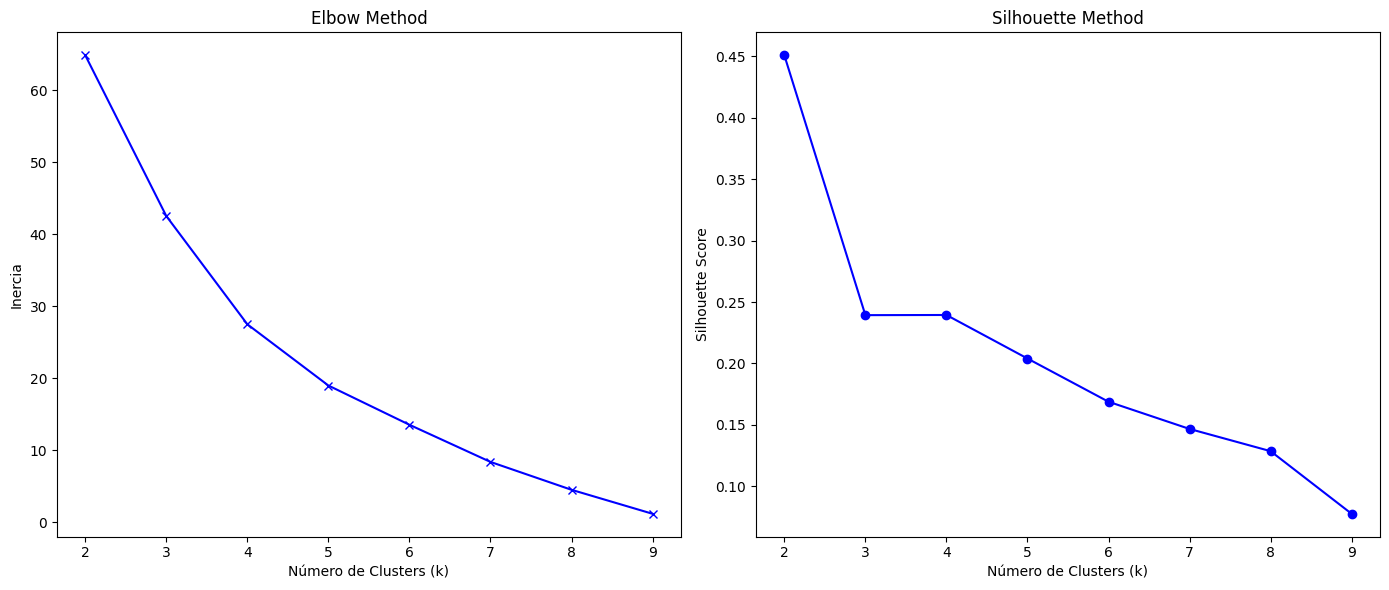

In [70]:
km_m.plot_elbow_silhouette(scaled_df, 9)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


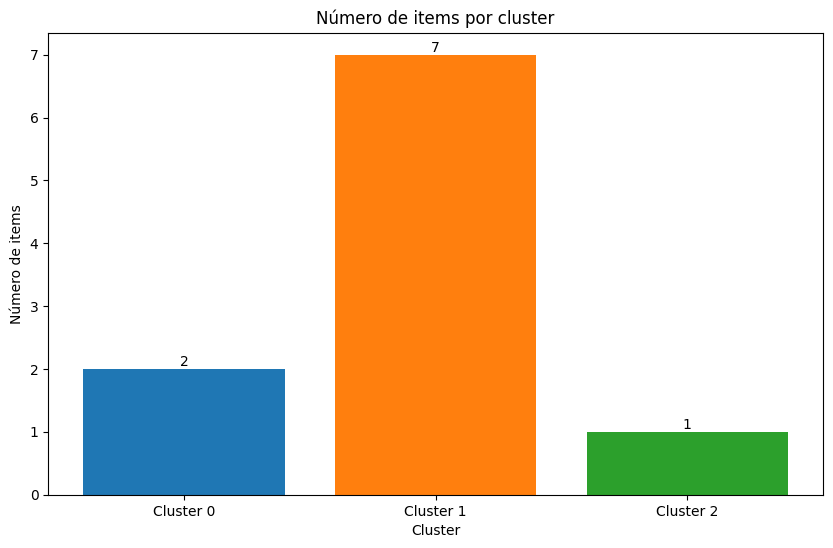

,COUNT(sales),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(week)),MEAN(sales.PERCENTILE(year)),MEAN(sales.items.cluster_name_High Performance),MEAN(sales.items.cluster_name_Low Performance),MEAN(sales.items.cluster_name_Top Performance),SUM(sales.items.cluster_name_High Performance),SUM(sales.items.cluster_name_Low Performance),SUM(sales.items.cluster_name_Top Performance),PERCENTILE(COUNT(sales)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(SUM(sales.sell_price)),Cluster
store_code,,,,,,,,,,,,,,,,,
NYC_1,534101,51.929222,5.392711,0.545948,0.499550,0.494924,0.001301,0.272216,0.014254,695.0,145391.0,7613.0,0.9,0.9,0.9,0.9,0
NYC_2,474612,45.315173,5.466066,0.529254,0.501663,0.510060,0.001365,0.270166,0.015800,648.0,128224.0,7499.0,0.2,0.6,0.4,0.5,1
NYC_3,552278,71.507726,5.353441,0.599604,0.500831,0.498926,0.001280,0.272694,0.014989,707.0,150603.0,8278.0,1.0,1.0,1.0,1.0,2
NYC_4,482465,31.187712,5.299665,0.437866,0.500351,0.499109,0.001347,0.288245,0.015609,650.0,139068.0,7531.0,0.3,0.1,0.1,0.3,1
BOS_1,495985,38.995716,5.212343,0.453500,0.499493,0.491865,0.001280,0.290037,0.015444,635.0,143854.0,7660.0,0.6,0.3,0.3,0.4,1


In [71]:
# Apreciamos varias opciones 3
optimal_k = 3

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

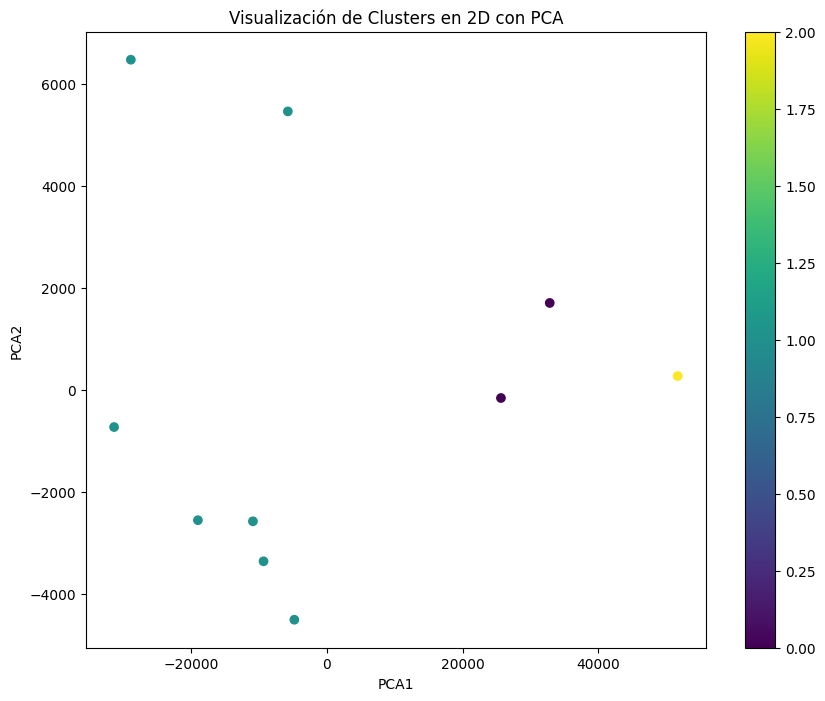

,PCA1,PCA2,Cluster
0,32826.299555,1702.281418,0
1,-28905.417930,6471.691985,1
2,51685.711439,269.446863,2
3,-19020.444161,-2557.619440,1
4,-4811.129796,-4508.979714,1


In [72]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 0.98
Principal Component 2: 0.02


array([0.98275124, 0.01722001])

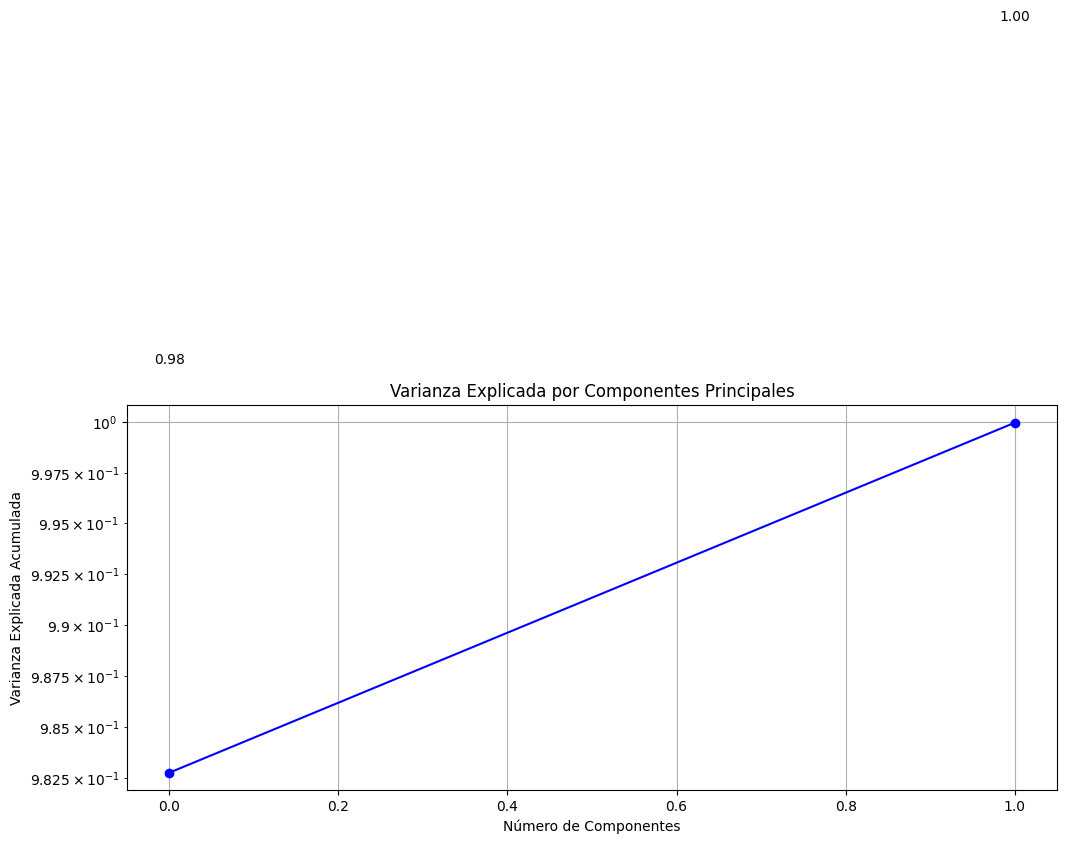

In [73]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 2)

display(explained_variance)

### Importancia caracteristicas

Cat cols: 0
Num cols: 16


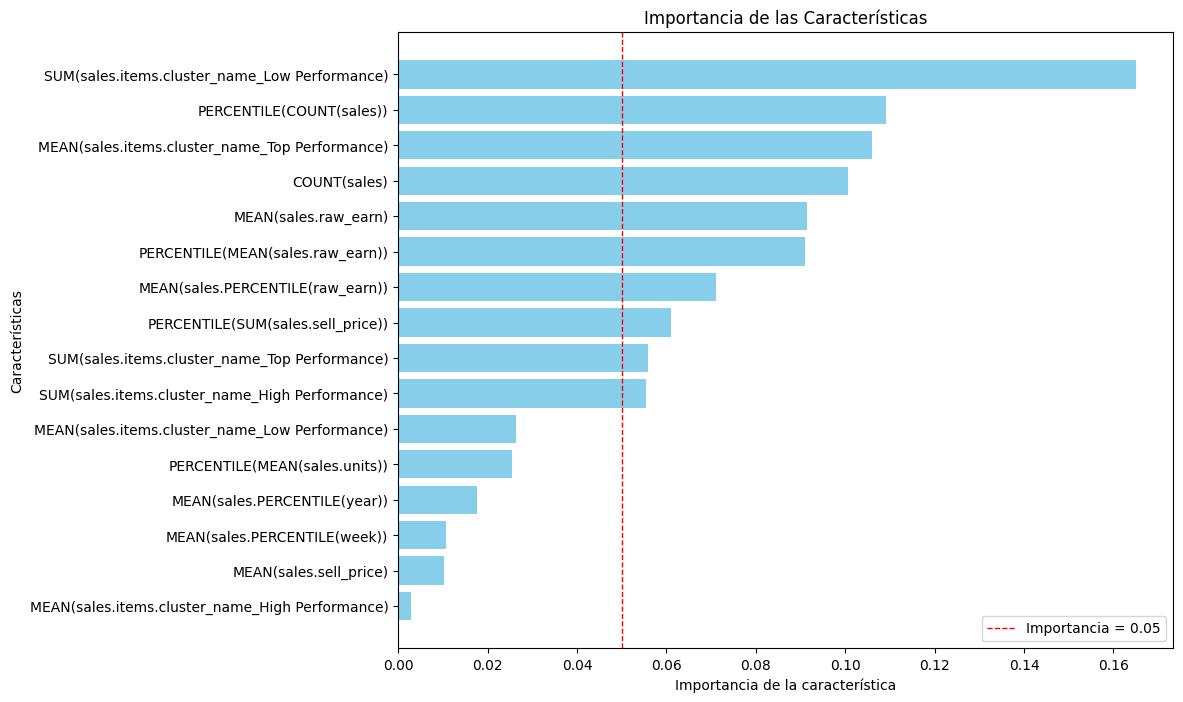

,Feature,Importance
0,SUM(sales.items.cluster_name_Low Performance),0.165103
1,PERCENTILE(COUNT(sales)),0.109053
2,MEAN(sales.items.cluster_name_Top Performance),0.105956
3,COUNT(sales),0.100571
4,MEAN(sales.raw_earn),0.091425
5,PERCENTILE(MEAN(sales.raw_earn)),0.091097
6,MEAN(sales.PERCENTILE(raw_earn)),0.071162
7,PERCENTILE(SUM(sales.sell_price)),0.060954
8,SUM(sales.items.cluster_name_Top Performance),0.055878
9,SUM(sales.items.cluster_name_High Performance),0.055519


In [74]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

## Dim redux

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


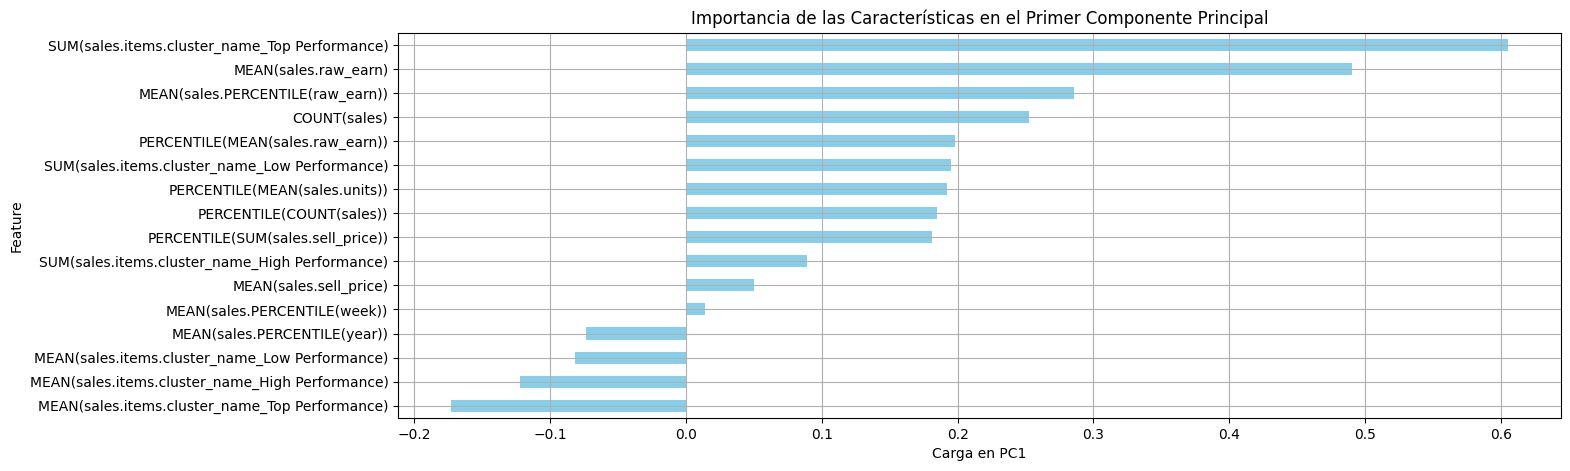

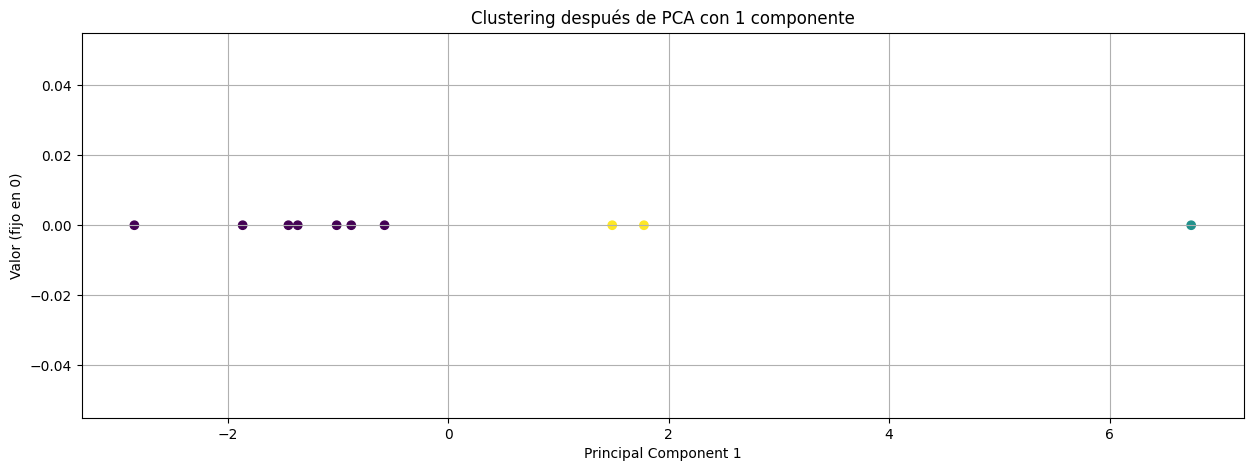

In [75]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

## Descripcion de clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,COUNT(sales),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(week)),MEAN(sales.PERCENTILE(year)),MEAN(sales.items.cluster_name_High Performance),MEAN(sales.items.cluster_name_Low Performance),MEAN(sales.items.cluster_name_Top Performance),SUM(sales.items.cluster_name_High Performance),SUM(sales.items.cluster_name_Low Performance),SUM(sales.items.cluster_name_Top Performance),PERCENTILE(COUNT(sales)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(SUM(sales.sell_price)),PC1,Cluster
0,1.154883,0.908654,0.883771,1.121865,-0.231087,-0.248036,0.115701,-0.597458,-1.875832,0.691729,0.449984,-0.043564,0.777778,0.777778,0.777778,0.777778,1.775099,2
1,-0.553123,0.044804,1.525698,0.801667,1.151989,0.782157,0.822707,-0.728980,0.502362,-0.015038,-1.424757,-0.946535,-0.777778,0.111111,-0.333333,-0.111111,-1.450863,0
2,1.676768,3.465769,0.540119,2.150999,0.607515,0.024358,-0.117117,-0.566804,-0.745541,0.872180,1.019166,5.223762,1.000000,1.000000,1.000000,1.000000,6.740622,1
3,-0.327653,-1.800360,0.069526,-0.951202,0.293017,0.036781,0.623232,0.430697,0.208855,0.015038,-0.240526,-0.693069,-0.555556,-1.000000,-1.000000,-0.555556,-2.848497,0
4,0.060523,-0.780570,-0.694630,-0.651341,-0.268662,-0.456237,-0.115701,0.545663,-0.045520,-0.210526,0.282134,0.328713,0.111111,-0.555556,-0.555556,-0.333333,-1.012961,0


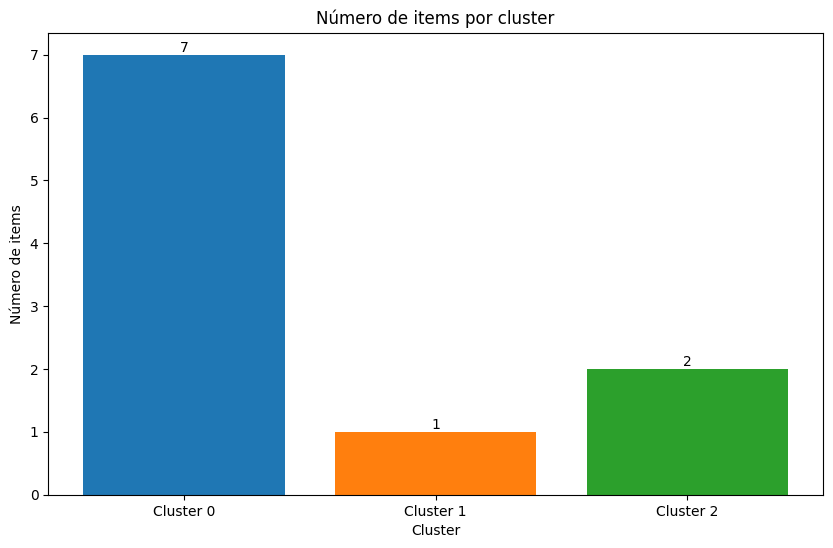

In [78]:
# Ejecutar PCA y clustering
optimal_k = 3
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

In [80]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
description_df = description_df[sorted(description_df.columns)]
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,0,1,2
SUM(sales.items.cluster_name_Top Performance),-0.300424,5.223762,0.431683
MEAN(sales.raw_earn),-0.553466,3.465769,0.650335
MEAN(sales.PERCENTILE(raw_earn)),-0.204486,2.150999,0.686163
COUNT(sales),-0.221934,1.676768,1.048379
PERCENTILE(MEAN(sales.raw_earn)),-0.333333,1.000000,0.666667
SUM(sales.items.cluster_name_Low Performance),-0.413868,1.019166,0.470078
PERCENTILE(MEAN(sales.units)),-0.301587,1.000000,0.555556
PERCENTILE(COUNT(sales)),-0.333333,1.000000,0.666667
PERCENTILE(SUM(sales.sell_price)),-0.333333,1.000000,0.666667
SUM(sales.items.cluster_name_High Performance),0.068743,0.872180,0.165414


In [81]:
# Añadimos clusters a df_items
df_shops = df_shops.reset_index(drop=True) # Recuperamos indices originales

df_shops_with_clusters = df_shops.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_shops_with_clusters.head()

,store_code,region,store,Cluster
0,NYC_1,New York,Greenwich_Village,2
1,NYC_2,New York,Harlem,0
2,NYC_3,New York,Tribeca,1
3,NYC_4,New York,Brooklyn,0
4,BOS_1,Boston,South_End,0


In [82]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Low Sales and Poor Performance',
        'description': 'Tiendas con un bajo rendimiento en ventas y baja participación en los productos de alto desempeño. Los ingresos y las ventas son consistentemente bajos, con un mal desempeño en los productos que generan mayores ingresos. Estas tiendas no logran destacar ni en términos de cantidad de ventas ni en la variabilidad de los precios.'
    },
    1: {
        'cluster_name': 'Top Performers with High Sales Volume',
        'description': 'Tiendas que presentan un alto rendimiento en ventas, especialmente con productos de alto desempeño. Este grupo domina en términos de ingresos brutos y participa activamente en los productos de mayor demanda. Muestran también una fuerte presencia en las ventas totales y una alta variabilidad en los precios de venta.'
    },
    2: {
        'cluster_name': 'Moderate Performance and Balanced Sales',
        'description': 'Tiendas con un rendimiento moderado que equilibran entre productos de bajo y alto desempeño. Las ventas y los ingresos son estables, con una variabilidad intermedia en los ingresos. Aunque no dominan en términos de productos de mayor demanda, estas tiendas presentan un desempeño sólido y consistente.'
    }
}



cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
shops_with_cluster_info = df_shops_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `shops_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(shops_with_cluster_info.head())

,store_code,region,store,Cluster,cluster_name,description
0,NYC_1,New York,Greenwich_Village,2,Moderate Performance and Balanced Sales,Tiendas con un rendimiento moderado que equili...
1,NYC_2,New York,Harlem,0,Low Sales and Poor Performance,Tiendas con un bajo rendimiento en ventas y ba...
2,NYC_3,New York,Tribeca,1,Top Performers with High Sales Volume,Tiendas que presentan un alto rendimiento en v...
3,NYC_4,New York,Brooklyn,0,Low Sales and Poor Performance,Tiendas con un bajo rendimiento en ventas y ba...
4,BOS_1,Boston,South_End,0,Low Sales and Poor Performance,Tiendas con un bajo rendimiento en ventas y ba...


## Guardar CSV

In [83]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_products_mix.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# shops_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **TIENDAS: RANGO PRECIOS**  
  
identificar tiendas que manejan productos en diferentes rangos de precios
___
___

In [ ]:
fc_config_price_range = {
    'target_df': 'shops',
    'agg_primitives': [
        'min',  # Precio mínimo de productos vendidos en cada tienda
        'max',  # Precio máximo de productos vendidos en cada tienda
        'mean',  # Precio promedio de productos vendidos en cada tienda
        'std',  # Desviación estándar de precios
    ],
    'trans_primitives': [
        'month',  # Para ver si el rango de precios varía según la estacionalidad
    ],
    'max_depth': 2
}


## Seleccion / Creacion caracteristicas

## Preprocesamiento datos

## Kmeans

## Descripcion de clusters

## Guardar CSV

# **TIENDAS: SALES w EVENTS**
___
___

## Creacion caracteristicas

In [ ]:
# OHE para columna event en df_ws usando sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

# Seleccionar la columna 'event' para codificar
events = df_ws[['event']]

# Crear el OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Ajustar y transformar los eventos con OHE
event_encoded = ohe.fit_transform(events)

# Crear un DataFrame con las columnas codificadas
event_encoded_df = pd.DataFrame(event_encoded, columns=ohe.get_feature_names_out(['event']))

# Concatenar con el DataFrame original de ventas
df_ws_ohe = pd.concat([df_ws.reset_index(drop=True), event_encoded_df], axis=1)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
display(df_ws_ohe.head())

,item,store_code,year,week,units,sell_price,raw_earn,event,event_Easter,event_NewYear,event_None,event_Ramadan starts,event_SuperBowl,event_Thanksgiving
0,ACCESORIES_1_004,BOS_1,2011,4,3.0,5.77,17.32,None,0.0,0.0,1.0,0.0,0.0,0.0
1,ACCESORIES_1_004,BOS_2,2011,4,8.0,5.77,46.18,None,0.0,0.0,1.0,0.0,0.0,0.0
2,ACCESORIES_1_004,NYC_2,2011,4,9.0,5.77,51.95,None,0.0,0.0,1.0,0.0,0.0,0.0
3,ACCESORIES_1_004,NYC_4,2011,4,2.0,5.77,11.54,None,0.0,0.0,1.0,0.0,0.0,0.0
4,ACCESORIES_1_004,PHI_1,2011,4,3.0,5.77,17.32,None,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Seteamos index de df_shops a columna store_code
# df_shops.set_index('store_code', inplace=True)
df_shops.head()

,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


In [ ]:
import featuretools as ft

# Crear un EntitySet
es = ft.EntitySet(id='sales_data')

# Agregar entidades
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="sales", dataframe=df_ws_ohe, index="id",
                      time_index="week",)
                      # secondary_time_index={'year': ['units', 'sell_price', 'raw_earn']})

# Definir relaciones
es = es.add_relationship("items", "item", "sales", "item")
es = es.add_relationship("shops", "store_code", "sales", "store_code")

# Generar características automáticas, ahora centradas en "items"
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="shops",  # Objetivo: productos
                                      agg_primitives=[
                                          'min',               # Mínimo
                                          'max',               # Máximo
                                          'mean',              # Promedio
                                          'std',               # Desviación estándar
                                          'sum',               # Suma
                                          'count'              # Totales
                                      ],
                                      trans_primitives=[
                                          'month',  # Extrae el mes para observar patrones estacionales a nivel semanal
                                          'is_weekend'  # Indica si la semana incluye fines de semana
                                      ],  # Primitivas de transformación, usando 'year'
                                      max_depth=2)

feature_matrix.head(10)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

,COUNT(sales),MAX(sales.event_Easter),MAX(sales.event_NewYear),MAX(sales.event_None),MAX(sales.event_Ramadan starts),MAX(sales.event_SuperBowl),MAX(sales.event_Thanksgiving),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),...,SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),SUM(sales.sell_price),SUM(sales.units),SUM(sales.week),SUM(sales.year)
store_code,,,,,,,,,,,,,,,,,,,,,
NYC_1,534101,1.0,1.0,1.0,1.0,1.0,1.0,4153.32,41.20,1697.0,...,24208.0,383510.0,48610.0,11297.0,19167.0,27735449.19,2880252.29,7698216.0,13861451.0,1.075428e+09
NYC_2,474612,1.0,1.0,1.0,1.0,1.0,1.0,1613.52,41.20,638.0,...,22342.0,340162.0,42457.0,10125.0,17402.0,21507125.12,2594260.38,5685475.0,12374682.0,9.556815e+08
NYC_3,552278,1.0,1.0,1.0,1.0,1.0,1.0,8623.37,41.20,3976.0,...,25413.0,396934.0,49363.0,11697.0,20217.0,39492143.82,2956587.60,11188180.0,14373324.0,1.112039e+09
NYC_4,482465,1.0,1.0,1.0,1.0,1.0,1.0,1744.99,41.20,567.0,...,21688.0,346615.0,43418.0,10235.0,17571.0,15046979.58,2556902.75,4103676.0,12542513.0,9.714673e+08
BOS_1,495985,1.0,1.0,1.0,1.0,1.0,1.0,2219.70,65.77,1676.0,...,22053.0,356953.0,44488.0,10617.0,17956.0,19341290.34,2585243.70,5595292.0,12871784.0,9.986713e+08
BOS_2,526682,1.0,1.0,1.0,1.0,1.0,1.0,3453.66,38.52,2076.0,...,23648.0,378785.0,47207.0,11167.0,18899.0,25266833.17,2782869.17,7214384.0,13656819.0,1.060475e+09
BOS_3,491769,1.0,1.0,1.0,1.0,1.0,1.0,6968.46,41.20,1215.0,...,22167.0,353750.0,43684.0,10604.0,17925.0,21947204.50,2596692.90,6089330.0,12783517.0,9.901994e+08
PHI_1,497065,1.0,1.0,1.0,1.0,1.0,1.0,1079.95,44.85,690.0,...,23609.0,355522.0,43980.0,10623.0,18687.0,18235414.81,2671350.29,5149062.0,12885073.0,1.000916e+09
PHI_2,470736,1.0,1.0,1.0,1.0,1.0,1.0,3808.76,76.83,1161.0,...,21514.0,338850.0,42202.0,10031.0,17117.0,21658583.43,2469603.66,6544012.0,12283659.0,9.478872e+08


In [ ]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: COUNT(sales)>: The number of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_Easter)>: The maximum of the "event_Easter" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_NewYear)>: The maximum of the "event_NewYear" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_None)>: The maximum of the "event_None" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_Ramadan starts)>: The maximum of the "event_Ramadan starts" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_SuperBowl)>: The maximum of the "event_SuperBowl" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_Thanksgiving)>: The maximum of the "event_Thanksgiving" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.raw_earn)>: The maximum of t

## Seleccion caracteristicas

In [ ]:
# V3
substrings = ['(sales)', '(sales.'] # Nos quedamos solo con las que afectan a ventas -> SON TODAS EN ESTE CASO

print(f'Length All features: {len(features_descriptions)}')

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length All features: 26
Length Feats Selected: 26
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 26
Shape after filtering: 14
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,COUNT(sales),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.week),MEAN(sales.year),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.sell_price),STD(sales.units),STD(sales.week),STD(sales.year)
store_code,,,,,,,,,,,,,,
NYC_1,534101,4153.32,41.20,1697.0,51.929222,5.392711,25.952865,2013.528791,0.07,89.614280,4.335884,29.263064,15.217839,1.494006
NYC_2,474612,1613.52,41.20,638.0,45.315173,5.466066,26.073260,2013.605870,0.24,58.430267,4.404013,19.189855,15.327575,1.512879
NYC_3,552278,8623.37,41.20,3976.0,71.507726,5.353441,26.025523,2013.549663,0.01,130.058981,4.309431,46.523097,15.285107,1.492768
NYC_4,482465,1744.99,41.20,567.0,31.187712,5.299665,25.996731,2013.549835,0.04,42.174182,4.288933,13.680758,15.247461,1.499930
BOS_1,495985,2219.70,65.77,1676.0,38.995716,5.212343,25.951962,2013.511169,0.12,66.422400,4.178037,25.052432,15.243287,1.507499


## Preprocesamiento de los datos

In [ ]:
from modules import preprocessing_module as pm

scaled_df = pm.preprocess_features(feature_matrix_renamed)

scaled_df.head()

Cat cols: 0
Num cols: 14


,COUNT(sales),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.week),MEAN(sales.year),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.sell_price),STD(sales.units),STD(sales.week),STD(sales.year)
0,1.154883,0.596752,0.000000,0.282982,0.908654,0.883771,-0.253913,-0.248072,0.000000,0.265447,0.572092,0.013180,-1.288504,-0.376274
1,-0.553123,-0.554384,0.000000,-0.908579,0.044804,1.525698,1.198394,0.762306,3.090909,-0.784661,1.267783,-0.939507,1.195378,0.949179
2,1.676768,2.622752,0.000000,2.847257,3.465769,0.540119,0.622557,0.025528,-1.090909,1.627404,0.301967,1.645569,0.234109,-0.463267
3,-0.327653,-0.494796,0.000000,-0.988467,-1.800360,0.069526,0.275243,0.027774,-0.545455,-1.332077,0.092652,-1.460536,-0.618009,0.039718
4,0.060523,-0.279639,1.270424,0.259353,-0.780570,-0.694630,-0.264799,-0.479078,0.909091,-0.515529,-1.039763,-0.385046,-0.712472,0.571338


## Kmeans

In [ ]:
from modules import kmeans_module as km_m

### Elbow & Silouette

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

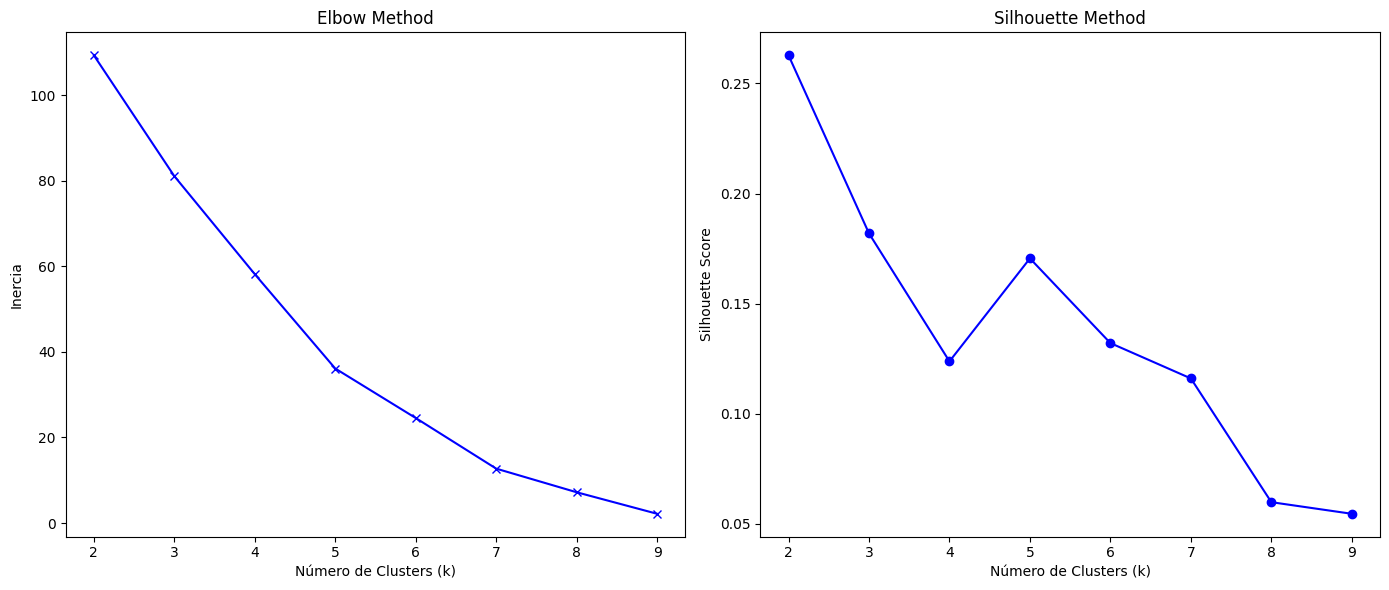

In [ ]:
km_m.plot_elbow_silhouette(scaled_df, 9) # No podemos usar más de n_shops - 1

-   **Método del codo (Inercia)**: El gráfico de la izquierda muestra que la inercia disminuye significativamente hasta k=3. Después de eso, las disminuciones son menos pronunciadas, lo que indica un "codo" en k=3k = 3k=3.

-   **Método del coeficiente silhouette**: El gráfico de la derecha muestra que el puntaje del coeficiente silhouette es más alto en k=3, lo que sugiere que esta es la mejor opción en términos de cohesión y separación de clústeres.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


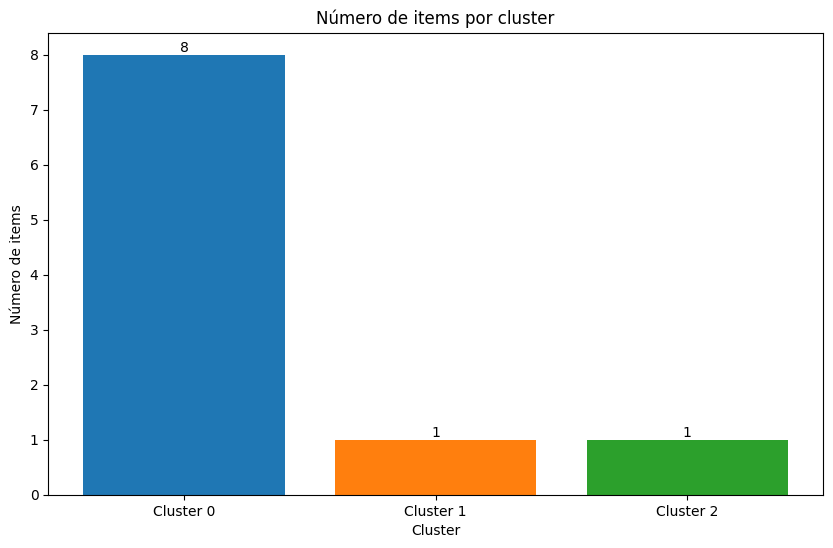

,COUNT(sales),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.week),MEAN(sales.year),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.sell_price),STD(sales.units),STD(sales.week),STD(sales.year),Cluster
store_code,,,,,,,,,,,,,,,
NYC_1,534101,4153.32,41.20,1697.0,51.929222,5.392711,25.952865,2013.528791,0.07,89.614280,4.335884,29.263064,15.217839,1.494006,0
NYC_2,474612,1613.52,41.20,638.0,45.315173,5.466066,26.073260,2013.605870,0.24,58.430267,4.404013,19.189855,15.327575,1.512879,0
NYC_3,552278,8623.37,41.20,3976.0,71.507726,5.353441,26.025523,2013.549663,0.01,130.058981,4.309431,46.523097,15.285107,1.492768,2
NYC_4,482465,1744.99,41.20,567.0,31.187712,5.299665,25.996731,2013.549835,0.04,42.174182,4.288933,13.680758,15.247461,1.499930,0
BOS_1,495985,2219.70,65.77,1676.0,38.995716,5.212343,25.951962,2013.511169,0.12,66.422400,4.178037,25.052432,15.243287,1.507499,0


In [ ]:
optimal_k = 3 # Segun graficas

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

In [ ]:
feature_matrix_with_clusters.shape

(10, 15)

### Analisis

#### PCAs

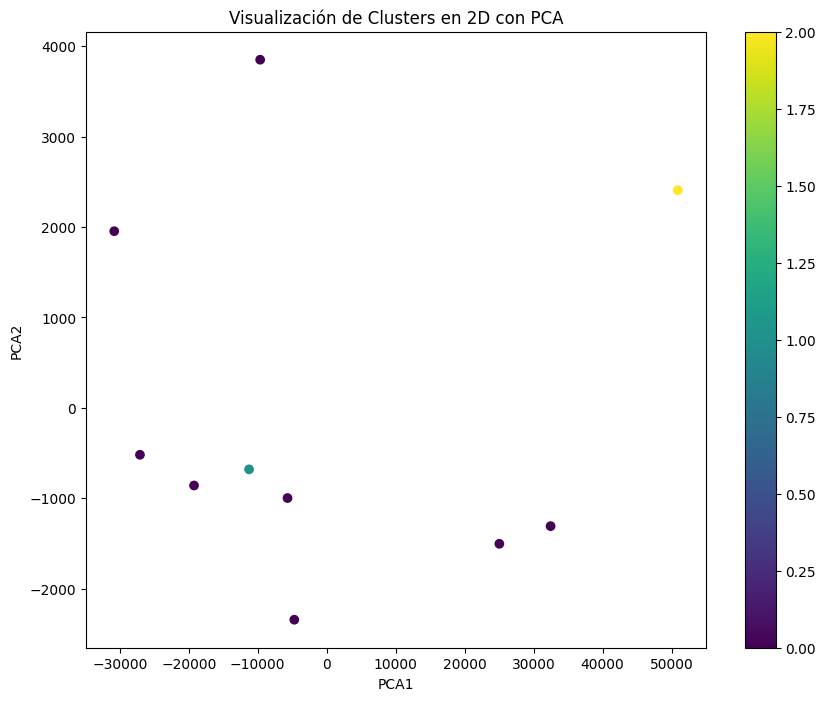

,PCA1,PCA2,Cluster
0,32464.726991,-1308.364494,0
1,-27079.178570,-519.225667,0
2,50917.598876,2407.203117,2
3,-19236.392246,-858.659379,0
4,-5682.863702,-997.552013,0


In [ ]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 0.99


array([0.99422952])

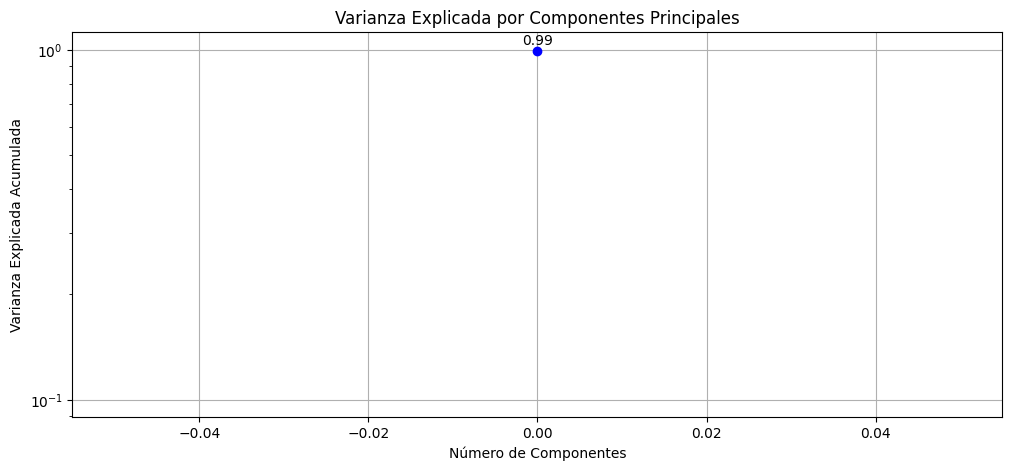

In [ ]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

display(explained_variance)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 14


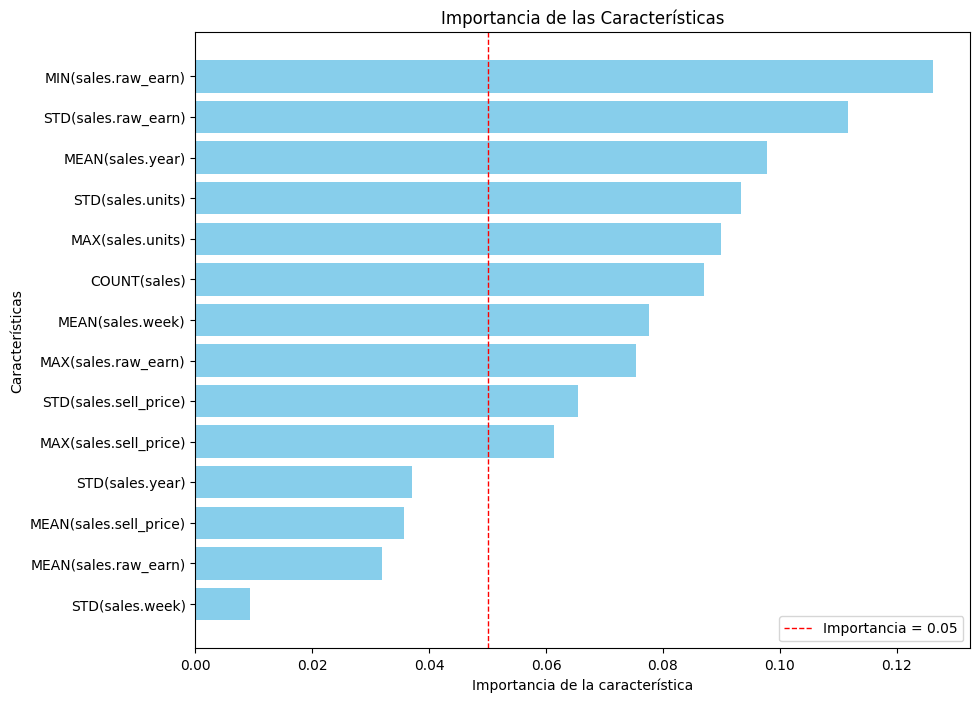

,Feature,Importance
0,MIN(sales.raw_earn),0.126287
1,STD(sales.raw_earn),0.111695
2,MEAN(sales.year),0.097851
3,STD(sales.units),0.093375
4,MAX(sales.units),0.090000
5,COUNT(sales),0.087077
6,MEAN(sales.week),0.077533
7,MAX(sales.raw_earn),0.075442
8,STD(sales.sell_price),0.065444
9,MAX(sales.sell_price),0.061295


In [ ]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
feats_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(feats_importance_df[feats_importance_df['Importance'] >= IMPORTANCE_THRES])

### Dimension Redux

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


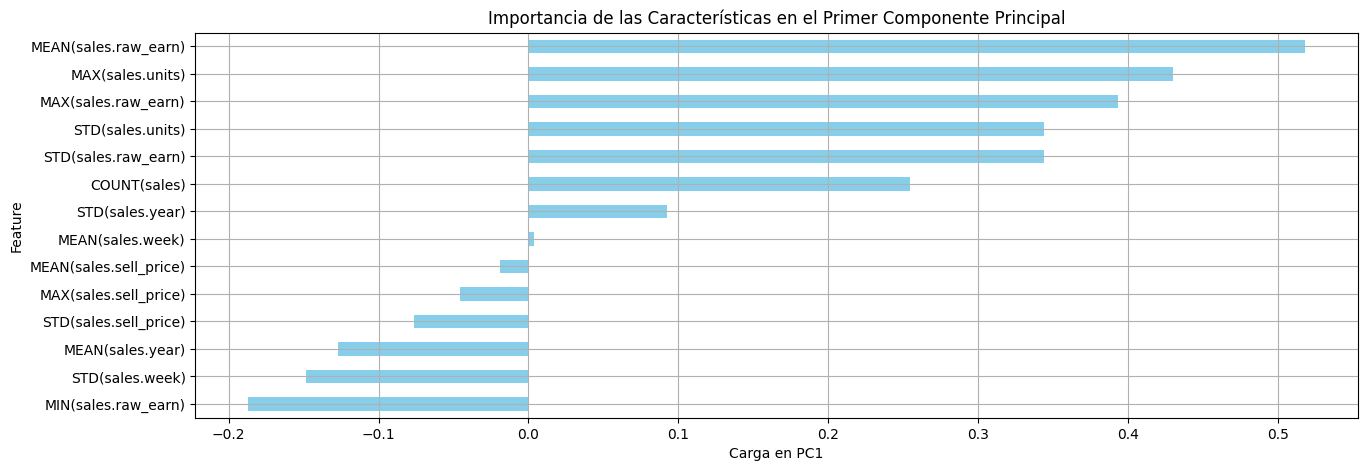

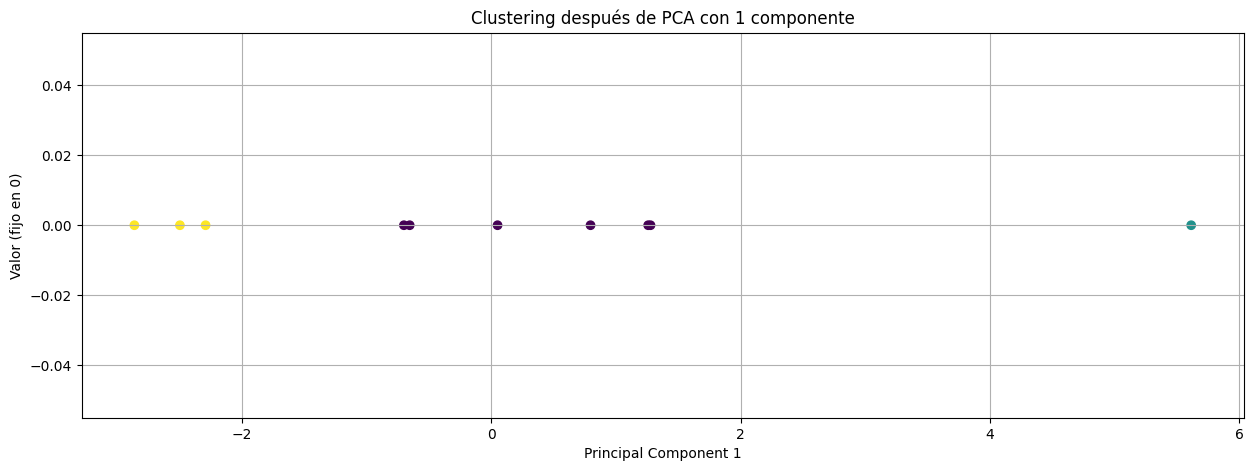

In [ ]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

In [ ]:
# El segundo componente es residual
# pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,COUNT(sales),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.week),MEAN(sales.year),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.sell_price),STD(sales.units),STD(sales.week),STD(sales.year),PC1,Cluster
0,1.154883,0.596752,0.000000,0.282982,0.908654,0.883771,-0.253913,-0.248072,0.000000,0.265447,0.572092,0.013180,-1.288504,-0.376274,1.259132,0
1,-0.553123,-0.554384,0.000000,-0.908579,0.044804,1.525698,1.198394,0.762306,3.090909,-0.784661,1.267783,-0.939507,1.195378,0.949179,-2.289697,2
2,1.676768,2.622752,0.000000,2.847257,3.465769,0.540119,0.622557,0.025528,-1.090909,1.627404,0.301967,1.645569,0.234109,-0.463267,5.613150,1
3,-0.327653,-0.494796,0.000000,-0.988467,-1.800360,0.069526,0.275243,0.027774,-0.545455,-1.332077,0.092652,-1.460536,-0.618009,0.039718,-2.495529,2
4,0.060523,-0.279639,1.270424,0.259353,-0.780570,-0.694630,-0.264799,-0.479078,0.909091,-0.515529,-1.039763,-0.385046,-0.712472,0.571338,-0.699411,0


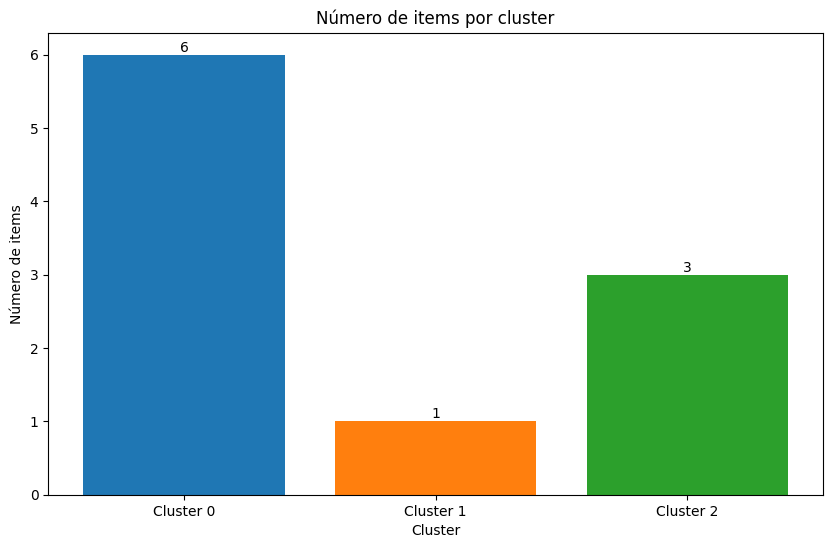

In [ ]:
# Ejecutar PCA y clustering
optimal_k = 3 # Segun graficas
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar descripciones

In [ ]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,0,2,1
MEAN(sales.raw_earn),0.044029,-0.945924,3.465769
MAX(sales.units),0.158837,-0.915706,2.847257
MAX(sales.raw_earn),0.437542,-0.615133,2.622752
STD(sales.units),0.057298,-1.188062,1.645569
STD(sales.raw_earn),0.153614,-1.092933,1.627404
COUNT(sales),0.222077,-0.263082,1.676768
STD(sales.year),-0.178562,-0.632557,-0.463267


In [ ]:
description_df[sorted(description_df.columns)]

,0,1,2
MEAN(sales.raw_earn),0.044029,3.465769,-0.945924
MAX(sales.units),0.158837,2.847257,-0.915706
MAX(sales.raw_earn),0.437542,2.622752,-0.615133
STD(sales.units),0.057298,1.645569,-1.188062
STD(sales.raw_earn),0.153614,1.627404,-1.092933
COUNT(sales),0.222077,1.676768,-0.263082
STD(sales.year),-0.178562,-0.463267,-0.632557


In [ ]:
# Asignacion clusters a shops
df_shops = df_shops.reset_index(drop=True) # Recuperamos indices originales

df_shops_with_clusters = df_shops.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_shops_with_clusters.head()

,store_code,region,store,Cluster
0,NYC_1,New York,Greenwich_Village,0
1,NYC_2,New York,Harlem,2
2,NYC_3,New York,Tribeca,1
3,NYC_4,New York,Brooklyn,2
4,BOS_1,Boston,South_End,0


In [ ]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Low Event Sensitivity with Super Bowl Influence',
        'description': 'Tiendas con baja sensibilidad a eventos como Thanksgiving y Año Nuevo, pero con un impacto positivo moderado durante el Super Bowl. Las ventas y los precios son estables, con baja variabilidad. Estas tiendas tienden a mantener precios consistentes durante todo el año.'
    },
    1: {
        'cluster_name': 'High Event and Price Variability',
        'description': 'Tiendas con alta sensibilidad a eventos clave como Acción de Gracias, Año Nuevo y Pascua. Las ventas en estas tiendas aumentan significativamente durante estos eventos, y también muestran alta variabilidad tanto en los precios de venta como en las ventas semanales. Estas tiendas tienen un comportamiento de ventas fluctuante y altamente influenciado por días festivos.'
    },
    2: {
        'cluster_name': 'Moderate Event Sensitivity with Stable Performance',
        'description': 'Tiendas con sensibilidad moderada a eventos como Acción de Gracias, con una respuesta estable a otros eventos importantes. Presentan una ligera variabilidad en los precios de venta y las ventas semanales, pero no son tan volátiles como otras tiendas durante los eventos festivos.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
shops_with_cluster_info = df_shops_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(shops_with_cluster_info.head())

,store_code,region,store,Cluster,cluster_name,description
0,NYC_1,New York,Greenwich_Village,0,Low Event Sensitivity with Super Bowl Influence,Tiendas con baja sensibilidad a eventos como T...
1,NYC_2,New York,Harlem,2,Moderate Event Sensitivity with Stable Perform...,Tiendas con sensibilidad moderada a eventos co...
2,NYC_3,New York,Tribeca,1,High Event and Price Variability,Tiendas con alta sensibilidad a eventos clave ...
3,NYC_4,New York,Brooklyn,2,Moderate Event Sensitivity with Stable Perform...,Tiendas con sensibilidad moderada a eventos co...
4,BOS_1,Boston,South_End,0,Low Event Sensitivity with Super Bowl Influence,Tiendas con baja sensibilidad a eventos como T...


## Guardamos csv

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_clusters_events_influence_sales.csv'

# Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
shops_with_cluster_info.to_csv(file_name, index=False)

# Descargar el archivo CSV
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>